### CRC183 Summer School "Machine Learning in Condensed Matter Physics"
# Hands-on session: Building deep learning models with JAX/Flax

## Installing JAX, NetKet & Co.

In today's session you will learn about basics of JAX and the Netket library. Installing NetKet is relatively straightforward and it will automatically install JAX as a dependency. 

For this Tutorial, **if you are running it locally on your machine**, we recommend that you create a clean virtual environment and install NetKet within: 

```bash
python3 -m venv netket
source netket/bin/activate
pip install --pre netket
```

If you are wondering why we use the flag ```--pre``` it is because today we will be working on a pre (beta) release of version 3.0. 

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
!pip install --pre -U netket

You can check that the installation was succesfull doing 

In [ ]:
import jax

## JAX

[JAX](https://github.com/google/jax) is a Python library that provides essential functionality for deep learning applications, namely

* **automatic differentiation**
* **vectorization**
* **just-in-time compilation** to GPU/TPU accelerators

It is being developed "for high-performance machine learning research" and as such well suited for physics applications. The abovementioned features are implemented in a system of composable function transformations that "process" Python functions.

## `jax.numpy`

The function transformations of JAX rely on functions being written in a "JAX-intellegible" form. For this purpose the `jax.numpy` sub-module emulates almost the whole NumPy functionality. When using JAX, any array operations should be written using `jax.numpy`.

In [ ]:
import numpy as np
import jax.numpy as jnp

The basic object is the `jnp.array`:

In [ ]:
arr = jnp.array([1,2,3])
print(arr)

NumPy arrays and `jax.numpy` arrays can be converted into each other:

In [ ]:
np_array = np.array(arr)
type(np_array)

In [ ]:
type(jnp.array(np_array))

Most NumPy functions have an equivalent in `jax.numpy`, e.g. `sum()`:

In [ ]:
print(jnp.sum(arr))

## JAX random numbers

JAX implements a pseudo-random number generator (PRNG) in the `jax.random` submodule. The JAX PRNG handles the state of the PRNG explicitly in the form of *keys* that have to be passed around, and which can be split in order to fork the PRNG state into new PRNGs.

Let's generate an initial key:

In [ ]:
seed=1234
key = jax.random.PRNGKey(seed)
print(key)

Any function in `jax.random` that generates random numbers takes a key as argument, e.g.

In [ ]:
jax.random.normal(key, (3,3))

Passing the same key results in the same set of random numbers

In [ ]:
jax.random.normal(key, (3,3))

To get a different sequence of random numbers, we need to generate a new key by splitting the original one:

In [ ]:
key, newkey = jax.random.split(key)

jax.random.normal(newkey, (3,3))

## Warning of "sharp edges" in JAX

The ability to perform the various function transformations imposes a number of **constraints on how those functions are written**. Before diving deeper into the JAX library, reading ["JAX - the sharp bits"](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html), which summarizes the main pitfalls when working with it, is highly recommended.

The most important points are

 * **Pure functions**: All input data have to be passed to the function as arguments and all results given as return values. Don't work with global variables or side effects. Some workarounds are needed to reconcile JAX with object-oriented code.
 * **Control flow** needs some care. Replace Python ``for``-loops or ``if``-branching with primitives from the ``jax.lax`` sub-module, [see documentation](https://jax.readthedocs.io/en/latest/jax.lax.html#control-flow-operators).
 * **JAX arrays are immutable**: As a python programmer you are used to updating array elements with ``array[13,:]=3.1415``. Unfortunately, this does not work with JAX arrays. Instead you need to use JAX's indexed update functionality, e.g. in this case ``array.at[13, :].set(3.1415)``. [See the documentation for details](https://jax.readthedocs.io/en/latest/jax.ops.html#indexed-update-operators).

## Flax

[Flax](https://github.com/google/flax) builds on JAX and provides a framework to easily define arbitrary deep learning models very similar to PyTorch. Moreover, typical building blocks of deep learning models are already implemented in the library.

As an example, let's define a simple feed-forward network with a single layer. It consists of a dense layer, i.e., an affine-linear transformation of the input followed by a $\text{ReLU}(\cdot)$ non-linearity giving the *activations*. Additionally, we include a reduction operation to obtain a single number as output, namely the sum of the activations:

$$
f_{W,b}(x) = \sum_i \text{ReLU}(W_{i,j}x_j+b_i)
$$

In Flax this neural network can be implemented as follows:

In [ ]:
import flax.linen as nn

class MyFFN(nn.Module):
    num_neurons: int
    
    @nn.compact
    def __call__(self, x):
        
        z = nn.Dense(self.num_neurons)(x) # affine-linear transformation of the input
        a = nn.relu(z) # non-linearity
        
        return jnp.sum(a)

The code above shows the basic syntax to define a custom model in Flax. A Flax model is a class that inherits from the abstract `flax.linen.Module` class. As part of it we have to implement a `__call__` method that defines how the network is evaluated for a given input.

In the example the `__call__` method is decorated with `@nn.compact`, because we are using the compact definition of a Flax model. This is possible for simple models where we do not have to specify an additional setup procedure for the initialization of the model. For more complex models a `setup` method can be defined for the initialization; in that case the `@nn.compact` decorator has to be dropped.

In addition, we defined the data field `num_neurons`. The data fields of the model class are initialized by the constructor and they can contain the hyperparameters of the model.

Finally, we use some of the pre-implemented building blocks, namely the `nn.Dense` layer for the affine-linear transformation and the activation function `nn.relu`.

Through the `nn.Module` base class our `MyFFN` class will have further methods that allow us to deal with the model. Below we will learn about `init` for parameter intialization and `apply` for the evaluation.

Now we can create an instance of this class, passing a value for the `num_neurons` hyperparameter to the constructor:

In [ ]:
net = MyFFN(num_neurons=123)

Before we can work with this model, we also need to get an initial set of parameters. For this purpose we have to call the model's `init` method, which takes an `jax.random.PRNGKey` and an exemplary input datum as arguments:

In [ ]:
example_input = jax.random.normal(jax.random.PRNGKey(4321), (28*28,))
params = net.init(jax.random.PRNGKey(1234), example_input)

The set of parameters is returned in the form of a tree:

In [ ]:
params

Now we can evaluate our neural network on the input data:

In [ ]:
net.apply(params, example_input)

To define models that don't rely on Flax's standard building blocks, parameters can be declared explicitly with the ``self.param`` method:

In [ ]:
class MyFFNfromScratch(nn.Module):
    num_neurons: int
    
    @nn.compact
    def __call__(self, x):
        
        W = self.param('W',
                    nn.initializers.lecun_normal(), # Initialization function
                    (self.num_neurons, x.shape[-1]))  # shape of the matrix
        
        b = self.param('b', nn.initializers.zeros, (self.num_neurons,))
        
        z = jnp.dot(W,x) + b # affine-linear transformation of the input
        a = nn.relu(z) # non-linearity
        
        return jnp.sum(a)

Initialization and evaluation is identical to the example above:

In [ ]:
net1 = MyFFNfromScratch(num_neurons=123)
params1 = net1.init(jax.random.PRNGKey(1234), example_input)
net1.apply(params1, example_input)

We can check, that in the ``params1`` dictionary we see our custom parameter names together with the random initial values.

In [ ]:
params1

# Function transformations in JAX

<h3 style="color: red">This part of the JAX notebook is not required for getting started with NetKet.</h3>

In the following part, we introduce some essential elements that make JAX so useful. In particular, we will look at 'just-in-time' compilation with `jit`, automatic differentation with `grad`, and vectorization with `vmap`. These are useful to know not only for working with neural networks, but more generally (see e.g. the neural_schrodinger and coulomb_gas notebooks)

## Just-in-time compilation with `jax.jit`

With just-in-time compilation JAX can generate compiled versions of Python functions that run on GPUs/TPUs if available and otherwise on the CPU. This can yield substantial performance gains.

Let's define an example function:

In [2]:
def f(x):
    return x*x

Now we can get a compiled version of the function with

In [3]:
f_jitd = jax.jit(f)

In [4]:
f(3)-f_jitd(3)

DeviceArray(0, dtype=int32)

#### Remarks
* The function returned by `jax.jit` is only compiled at the point when it is first called.
* The function is compiled for fixed shapes of the arguments that are given at the first call. Therefore, the first call can take substantially longer than subsequent calls.
* Calling a compiled function with different argument shapes will cause re-compilation.

## Automatic differentiation with `jax.grad`

`jax.grad` returns a function that computes the gradient of the input function with respect to its arguments:

In [16]:
df = jax.grad(f)

Since JAX function transformations are composable, we can also easily compute higher order derivatives:

In [ ]:
ddf = jax.grad(jax.grad(f))

Let's convince ourselves, that JAX's gradients are correct:

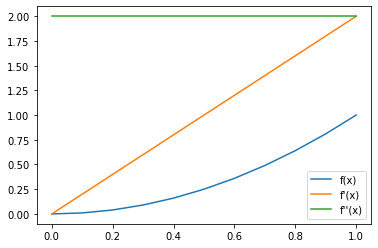

In [19]:
import matplotlib.pyplot as plt
x_list = jnp.arange(0,1.
                    1,.1)
f_values = jnp.array([f(x) for x in x_list])
df_values = jnp.array([df(x) for x in x_list])
ddf_values = jnp.array([ddf(x) for x in x_list])

plt.plot(x_list, f_values, label="f(x)")
plt.plot(x_list, df_values, label="f'(x)")
plt.plot(x_list, ddf_values, label="f''(x)")
plt.legend();

## Vectorization with `jax.vmap`

For a given function that operates on some input data, `jax.vmap` returns a vectorized version of that function, that applies the original function *element-wise* to vectors of input data.

This is very natural, since one focus of JAX is ultimately the execution of the Python code on GPUs. On the other hand, JAX inherits some of the Python issues with for-loops. Vectorizing an operation is often a good alternative to writing a for-loop.

Let's vectorize our gradient function:

In [24]:
df_vmapd = jax.vmap(df)

Now we can directly call `df_vmapd` on a list of input values and we do not need any more the construction `jnp.array([df(x) for x in x_list])` that we used above.

Let's check that the output of both versions is identical:

In [25]:
x_list = jnp.arange(0,1.1,.1)

# The vmap-ed function enables us to evaluate gradients directly on the list of x-values
df_values_with_vmap = df_vmapd(x_list)

df_values = jnp.array([df(x) for x in x_list])

df_values - df_values_with_vmap

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)